# Solutions Q17 - 20

In [1]:
# import all python add-ons etc that will be needed later on
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from scipy.integrate import quad,odeint
init_printing()                         # allows printing of SymPy results in typeset maths format
plt.rcParams.update({'font.size': 16})  # set font size for plots

## Q17 answer
The answer here is entirely up to you!

## Q18 answer
The grid search has the following form
(1) Set initial values of rate constants and increments in $k_1, k_2$.
(2) Outer loop 10 values. Inner loop 10 values.
(i) Calculate equation, compare with data, print residual.
(ii) Increment $k_1$.
End inner loop.
(iii) Set $k_1$ back to initial value. 
(iv) Increment $k_2$.
End outer loop.
(3) Plot results
The important part here is to match the data points ($15$ in total) with the 1500 used to integrate the equations. A simple way is to find the minimum between the times used to calculate the equations and the day ( $0 \to 15$) and to make an array of the integr values. This is array indx in the code below. 

Although this type of optimization is crude, it is simple to implement, and for a short calculation is not too time consuming. It is suitable in this instance, as both the calculated result and data are in numerical form and the derivatives with respect to the parameters $k_2$ and $k_1$ needed for more sophisticated search routines, such as Marquardt - Levenburg (Bevington 1969) are not available.

In [2]:
# SIR grid search 
#------------------------------
def EulerIntA(S0,In0,R0,Np,k1,k2):       
    
    h = (maxdays-t0)/Np
    EulerS  = np.zeros(Np,dtype=float)
    EulerIn = np.zeros(Np,dtype=float)
    EulerR  = np.zeros(Np,dtype=float)
    dtime   = np.zeros(Np,dtype=float)

    EulerS[0]  = S0
    EulerIn[0] = In0
    EulerR[0]  = In0
    dtime[0]   = t0
    S  = S0
    In = In0
    R  = In0
    D  = 0.0
    t  = 0.0
    for i in range(1,Np):                         # put derivatives in explicitely
        S = S  + h*(-k2*S*In )                    # h*derivative as rate eqn
        In= In + h*(k2*S*In-k1*In)
        R = R  + h*k1*In 
        EulerS[i]  = S
        EulerIn[i] = In
        EulerR[i]  = R
        dtime[i]   = t
        t = t + h
    pass
    return dtime,EulerS,EulerIn,EulerR
#------------------------------------

data = [1,3,7,25,72,222,282,256,233,189,123,70,25,11,4]    # data  in text 
num  = 763                                                 # initial number
k1   = 0.45
k2   = 0.00215

maxdays  = len(data)
numtimes = 100*maxdays                                     # number of time points   

S0 = num - 1
In0= 1
R0 = 0
t0 = 0
n  = 30

def gridsearch(k10,k20,n,maxdays,numtimes):
    
    resid = np.zeros((n,n),dtype = float)             # residual at point i,j
    xx = np.linspace(0.85*k20,1.125*k20, n  )      # k2 values 3k_2/(4n)
    yy = np.linspace(0.85*k10,1.125*k10, n  )      # k1
    
    dtime = np.linspace(0, maxdays, numtimes)           # numtimes number of integration time points
    indx = np.zeros( maxdays,dtype = int )
    for i in range(maxdays):                          # maxt is number of days i.e. length of data
        indx[i] = int(np.argmin( abs(dtime[:] - i) ) ) # indx is equivalent point; data and calc
    
    for k in range(n):
        for j in range(n):
            k1 = yy[k]
            k2 = xx[j]
            dtime,Sval,Inval,Rval = EulerIntA(S0,In0,R0,numtimes,k1,k2)
            resid[k,j] = np.sum( [(Inval[indx[i]] - data[i] )**2 for i in range(maxdays) ]  )/100
            pass

    return resid,xx,yy
#--------------------------------

resid, xx, yy = gridsearch(k1,k2,n,maxdays,numtimes)

minres = np.min(resid[:,:])      # minimum residual
mindx  = np.argmin(resid[:,:])   # index of minimum
ix = (mindx) % n 
iy = (mindx) // n
k1 = yy[iy]
k2 = xx[ix]
print('{:s} {:6.4f} {:s} {:10.4g} {:s} {:f}'.format('k1 = ',k1,', k2= ', k2, ', k2S0/k1 = ', k2*S0/k1) )

k1 =  0.4508 , k2=    0.002194 , k2S0/k1 =  3.709595


![Drawing](num-methods-fig37.png)

Figure 37. The contours are formed from the gridded data which is the residual between the experimental data and that calculated by the SIR model. The circle shows the minimum value of all the contours.  The contour values are arbitrary.
___________

## Q19 answer 
Comparing with an accurate result produced by python's internal algorithms, the simple Euler method fails even with $5000$ points in the integration.

The reason is not therefore of rounding errors but that the approximation to each step of the integral is not good enough. Using the modified Euler method significantly improves the calculation but even this fails if $v$ is larger than $10$. Using a more sophisticated Runge - Kutta algorithm even that than given in the text improves the accuracy of the calculation.

## Q20 answer 
Following the example in the text, the first thing is to estimate the parameters. Notice that $k_2$ and $S$ are always a product so that as $S_0$ is so large $k_2 $ will be very small. Then the algorithm of Q18 could be used, 

Modify the SIR code to include another array $\mathtt{EulerD}$ to hold the data for the number of deaths and modify the In data so that $\mathtt{k_1In \to (k_1+k_d)In}$ and add a term $\mathtt{D=D+hk_dD}$ etc. 

The data is very sensitive to the value of $k_d$, not surprisingly as only one term $k_dI$ determines its value. The best fit is found with $k_1 \approx 0.0415, k_2\approx 2.72\cdot 10^{-7}$. The data is shown in fig. 38. The rightmost figure shows the daily trend in Covid19 deaths, which is the numerical derivative $\Delta \text{data}/\Delta t)$ of the cumulative data. The fits are also shown on both plots.  They are quite good but not excellent. This is often the case with experimental data, and indicates that our model is rather simplified. One possibility is that the death rate is not correct and that this should also be varied. In this case a non-linear least squares method, such as described in Chapter 13 will have to be used.

![Drawing](num-methods-fig37a.png)

Figure 37a. Grid search method fit to the data. Middle. The calculated fit, black, and the data points,red. Right. The daily number of deaths and the corresponding fit. As can be seen the fit is not that good. 
_________
The code below shows one way of reading the data. As can be seen from the data it is clear when the second wave of the pandemic starts.

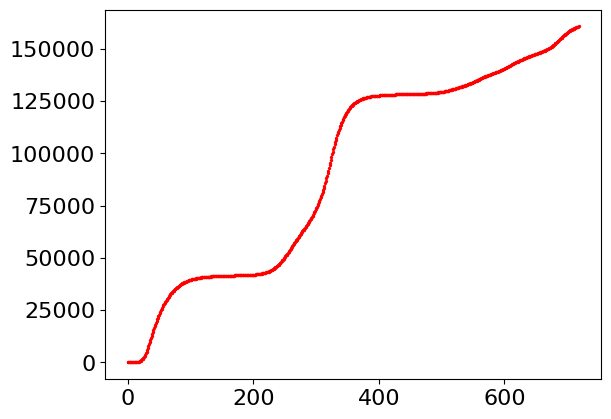

In [4]:
# data extracted from website uk.gov 
filename = 'UK-covid-deaths.txt'  # data is cumulative

with open(filename) as ff:                
    i=0
    for line in ff:
        temp = line.split(',')     # data is comma separated
ff.close()
alldata = [int(i) for i in temp]     # make list of integers

Lh = len(alldata)
day = np.linspace(0,Lh,Lh)
plt.scatter(day[:],alldata[::-1],s=2,color='red')

plt.show()